In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import tensorflow as tf
import tensorflow.keras as k
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, AveragePooling2D, Flatten, Dropout

In [29]:
path_folder = "/content/drive/MyDrive/Pancreatic_Image"
class_name = os.listdir(path_folder)
class_name

['Normal', 'Pancreatic_Tumor']

In [30]:
path_folder = "/content/drive/MyDrive/Pancreatic_Image"
class_name = os.listdir(path_folder)
class_name.sort()
print(class_name)
image_data = []
label_data = []
count = 0
for folder in class_name:
    images = os.listdir(path_folder + "/" + folder)
    print("Loading Folder -- {} " .format(folder), "The Count of Classes ==> ",count)
    for img in images:
        image = cv2.imread(path_folder + "/" + folder + "/" + img)
        image = cv2.resize(image, (224, 224))

        image_data.append(image)
        label_data.append(count)
    count += 1
print("---- Done ----------- ")

['Normal', 'Pancreatic_Tumor']
Loading Folder -- Normal  The Count of Classes ==>  0
Loading Folder -- Pancreatic_Tumor  The Count of Classes ==>  1
---- Done ----------- 


In [31]:
data = np.array(image_data)
data = data.astype("float32")
data = data/255.0

label = np.array(label_data)

In [32]:
print(data.shape)

(1000, 224, 224, 3)


In [33]:
label_num = to_categorical(label, len(class_name))

In [34]:
x_img, y_img = shuffle(data, label_num)
x_train, x_test, y_train, y_test = train_test_split(x_img, y_img, train_size=0.8)

In [35]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((800, 224, 224, 3), (800, 2), (200, 224, 224, 3), (200, 2))

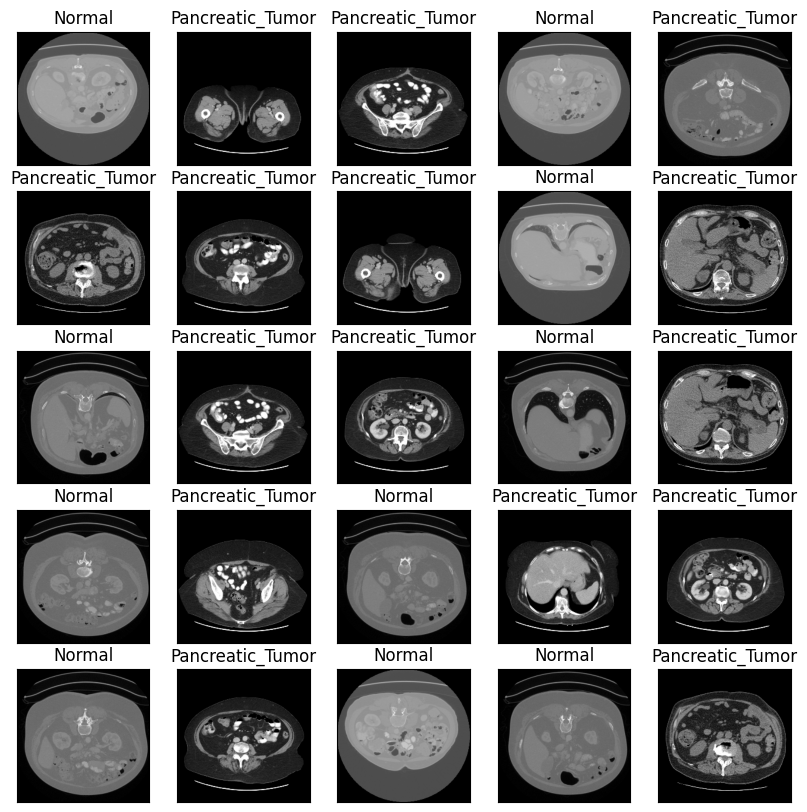

In [36]:
plt.figure(figsize=(10, 10))
for i in range(0, 25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i])
    plt.title(class_name[np.argmax(y_train[i])])

In [37]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Define the input layer with the correct input shape
input_layer = Input(shape=(224, 224, 3))

# Load the VGG16 model with the base layers frozen and no top classification layers
vgg16_base = VGG16(weights='imagenet', include_top=False, input_tensor=input_layer)

# Freeze all layers in the VGG16 base model
for layer in vgg16_base.layers:
    layer.trainable = False

# Add custom layers on top of VGG16
x = Flatten()(vgg16_base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(class_name), activation='softmax')(x)

# Define the full model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [38]:
# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=15,
    batch_size=32,
    verbose=1
)

Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 259ms/step - accuracy: 0.7483 - loss: 2.2549 - val_accuracy: 0.9800 - val_loss: 0.1033
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 219ms/step - accuracy: 0.9773 - loss: 0.1072 - val_accuracy: 0.9800 - val_loss: 0.0350
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 221ms/step - accuracy: 0.9865 - loss: 0.0430 - val_accuracy: 0.9900 - val_loss: 0.0263
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 215ms/step - accuracy: 0.9656 - loss: 0.0557 - val_accuracy: 0.9800 - val_loss: 0.0343
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 223ms/step - accuracy: 0.9695 - loss: 0.0629 - val_accuracy: 0.9800 - val_loss: 0.0409
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.9802 - loss: 0.0490 - val_accuracy: 0.9800 - val_loss: 0.0321
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 0.9823 - loss: 0.0408 - val_accuracy: 0.9800 - val_loss: 0.0334
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/step - accuracy: 0.9849 - loss: 0.0359 - val_accuracy

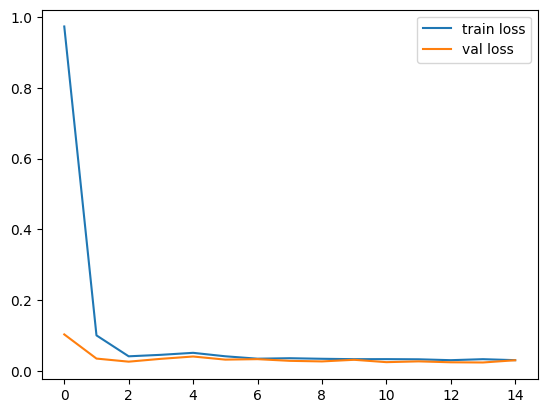

<Figure size 640x480 with 0 Axes>

In [39]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

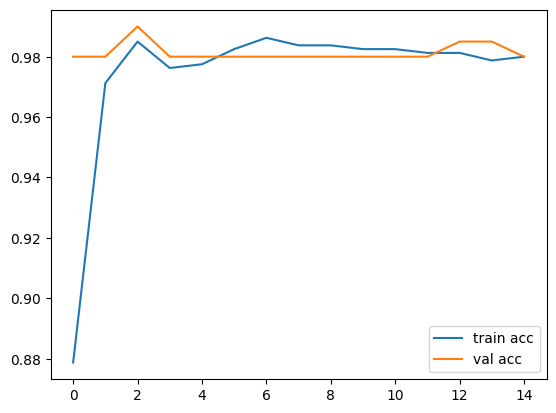

<Figure size 640x480 with 0 Axes>

In [40]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [41]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Define the input layer with the correct input shape
input_layer = Input(shape=(224, 224, 3))

# Load the ResNet50 model with pre-trained ImageNet weights, excluding the top layers
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_tensor=input_layer)

# Freeze all layers in the ResNet50 base model
for layer in resnet50_base.layers:
    layer.trainable = False

# Add custom layers on top of ResNet50
x = Flatten()(resnet50_base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(class_name), activation='softmax')(x)

# Define the full model
model1 = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model1.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])



In [42]:
# Train the model
history1 = model1.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=15,
    batch_size=32,
    verbose=1
)

Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 343ms/step - accuracy: 0.7348 - loss: 2.6381 - val_accuracy: 0.9800 - val_loss: 0.2579
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - accuracy: 0.9636 - loss: 0.3512 - val_accuracy: 0.9800 - val_loss: 0.1169
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.9823 - loss: 0.1050 - val_accuracy: 0.9800 - val_loss: 0.0891
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9788 - loss: 0.1239 - val_accuracy: 0.9800 - val_loss: 0.0972
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.9844 - loss: 0.0997 - val_accuracy: 0.9800 - val_loss: 0.0802
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.9829 - loss: 0.0896 - val_accuracy: 0.9800 - val_loss: 0.0804
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.9885 - loss: 0.0713 - val_accuracy: 0.9800 - val_loss: 0.0739
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.9806 - loss: 0.0956 - val_accuracy: 

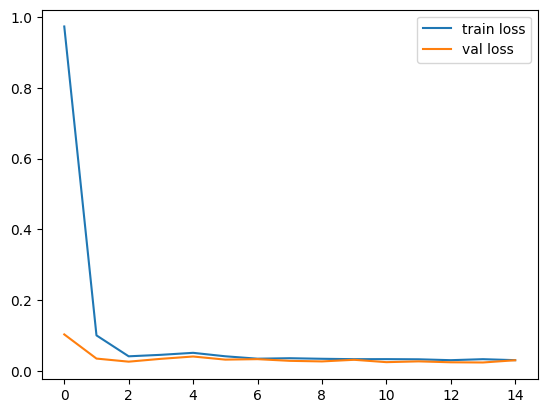

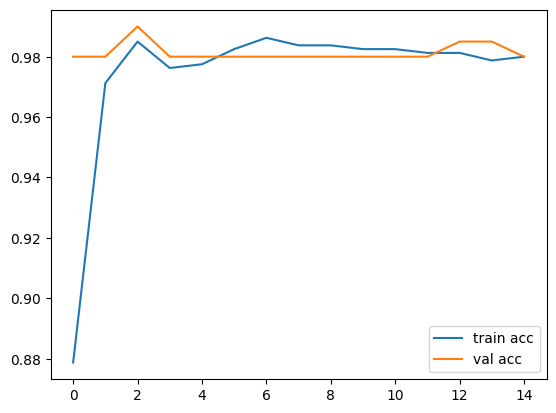

In [43]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [44]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Define the input layer with the correct input shape
input_layer = Input(shape=(224, 224, 3))

# Load the EfficientNetB0 model with pre-trained ImageNet weights, excluding the top layers
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_layer)

# Freeze all layers in the EfficientNet base model
for layer in efficientnet_base.layers:
    layer.trainable = False

# Add custom layers on top of EfficientNet
x = Flatten()(efficientnet_base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(class_name), activation='softmax')(x)

# Define the full model
model2 = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [45]:
# Train the model
history = model2.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=15,
    batch_size=32,
    verbose=1
)



Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 499ms/step - accuracy: 0.4982 - loss: 15.2251 - val_accuracy: 0.4950 - val_loss: 0.6913
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - accuracy: 0.4852 - loss: 0.7022 - val_accuracy: 0.4950 - val_loss: 1.3214
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.5013 - loss: 0.8147 - val_accuracy: 0.5050 - val_loss: 0.6931
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.4865 - loss: 0.7830 - val_accuracy: 0.5050 - val_loss: 0.6931
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.4968 - loss: 0.6996 - val_accuracy: 0.5050 - val_loss: 0.6931
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.4814 - loss: 0.6933 - val_accuracy: 0.5050 - val_loss: 0.6931
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.4822 - loss: 0.6933 - val_accuracy: 0.5050 - val_loss: 0.6931
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.4924 - loss: 0.6944 - val_accuracy: 0.5050

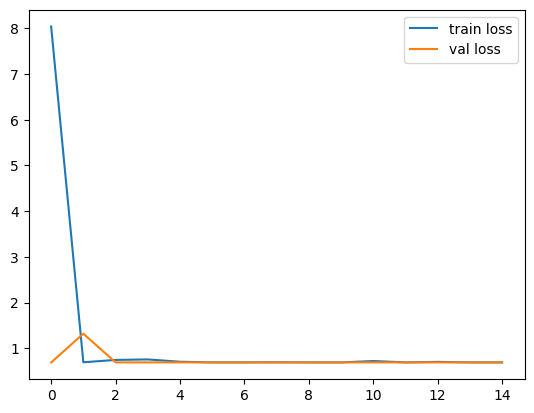

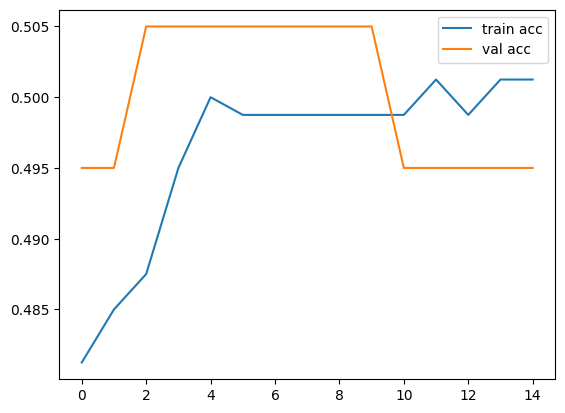

<Figure size 640x480 with 0 Axes>

In [46]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [59]:
model.save('Model.h5')

In [60]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('Model.h5')

In [62]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

def preprocess_image(img_path):
    # Load the image with the target size of (224, 224)
    image = load_img(img_path, target_size=(224, 224))
    # Convert the image to an array
    image = img_to_array(image)
    # Expand dimensions to match the model input (1, 224, 224, 3)
    image = np.expand_dims(image, axis=0)
    # Preprocess the image for VGG16
    image = preprocess_input(image)
    return image

def predict_image(img_path, model):
    # Preprocess the image
    processed_image = preprocess_image(img_path)
    # Make a prediction
    predictions = model.predict(processed_image)
    # Get the class label with the highest probability
    predicted_class = np.argmax(predictions, axis=1)[0]
    class_name=['Normal', 'Pancreatic_Tumor']
    class_label = class_name[predicted_class]
    return class_label

# Example usage:
img_path = '/content/drive/MyDrive/Pancreatic_Image/Normal/1-001.jpg'  # Replace with the path to the image you want to predict
predicted_label = predict_image(img_path, loaded_model)
print(f"The model predicts: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
The model predicts: Normal
